# Trabajo final diplomatura Data Science

## Fake News en Español

### Nos proponemos realizar un analisis sobre noticias falsas usando bases de datos ya confeccionadas, realizando el analisis exploratorio necesario para conseguir un dataframe suficientemente grande y consistente para luego poder aplicar los distintos modelos de aprendizaje supervizado que hemos aprendido.
### Una vez realizado los distintos modelos realizaremos webscraping a distintas paginas de noticias para probar los mismos y ver que modelo de los entrenados nos entrega mejores resultados

### Importamos las librerias necesarias para el analisis exploratorio

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import mitosheet
import pandas as pd
import pydotplus
import string
import nltk
from six import StringIO
from IPython.display import Image
from pydotplus import graph_from_dot_data
from nltk.corpus import stopwords, wordnet
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import PorterStemmer,WordNetLemmatizer,SnowballStemmer
from nltk.probability import FreqDist
from string import punctuation
import mtbpy
from wordcloud import WordCloud
import re
from pandas_profiling import ProfileReport

### Importamos el dataset a nuestro dataframe
#### Nuestros datos se encuentran en un archivo txt y los valores estan separados por tabulaciones, tambien necesitamos especificar la codificacion para no tener problemas con los acentos y ñ por ejemplo

In [169]:
df = pd.read_csv('dataset/fakeNews.txt',encoding='latin-1',delimiter='\t')

### Realizaremos un analisis exploratorio para entender el dataset

#### Imprimimos las keys para saber cuales son las dimensiones

In [170]:
df.keys()

Index(['Class', 'Text'], dtype='object')

#### Imprimimos las primeras filas del dataframe

In [171]:
df.head()

,Class,Text
0,True,"Algunas de las voces extremistas más conocidas de EE.UU., cuentas asociadas con al movimiento de la conocida como alt-right o ligadas a grupos antisemitas o xenófobos , han sido eliminadas de un plumazo de la redes sociales Facebook e Instagram. Se trat"
1,True,"Después de casi dos años y medio de luchas políticas y judiciales, Donald Trump ha presentado hoy su proyecto de inmigración para Estados Unidos . Es un proyecto elaborado por el yerno y asesor de Donald Trump, Jared Kushner, que sólo concreta una cosa:"
2,True,Dos periodistas birmanos de la agencia Reuters fueron liberados este martes al recibir un perdón del presidente de su país tras pasar año y medio en prisión por revelar una matanza del Ejército contra la minoría musulmana rohingya. Wa Lone y Kyaw Soe Oo
3,True,El Cuerpo Nacional de Policía ha detenido a cuatro personas acusadas de formar parte de un grupo criminal dedicado al tráfico de seres humanos en la frontera francoespañola de Irún (Gipuzkoa). Esta célula captaba extranjeros llegados en pateras y les of
4,True,El desfile de la firma en Roma se convierte en una oda a la libertad de las mujeres para decidir sobre sus propios cuerpos. Los Museos Capitolinos de Roma se transformaron la noche del martes en escenario sobre el que presentar la colección crucero 202


#### Imprimimos los ultimos registros del DF

In [5]:
df.tail()

,Class,Text
3563,True,"Meryl Streep disfrutó unos premios Oscar tan mexicanos ¡que se vino a México!. Streep va de ser 'directora' del Washington Post a la de 'Runway' a compradora de artesanías en Guanajuato.. La multipremiada actriz estadounidense Meryl Streep, que ya ha ganado el premio como Mejor actriz por la Academia cinematográfica de su país, parece que el número de Coco y las dos pasadas por el escenario de Guillermo del Toro la inspiraron a volver a México.. Por medio de redes sociales, dos jóvenes de San Miguel de Allende, Guanajuato, que trabajan en las tiendas de artesanías locales tuvieron un encuentro con la famosa actriz mientras paseaba por la ciudad.. HuffPost México contactó al joven que volvió viral la presencia de Streep, ""la señora es muy amable y fue muy receptiva, yo me emocioné mucho cuando la reconocí y la abracé y ella a mi"", relata Alex.. El joven de *NUMBER* años que trabaja en la tienda de ropa ubicada en San Francisco *NUMBER*, en la Plaza Principal en el centro de San Miguel de Allende comentó ""venía acompañada de otras dos mujeres a las que no reconocí, ella estaba de prisa, pero fue muy linda en tomarse unas fotos"".. La experiencia duró apenas unos minutos, suficientes para poder saludar a una de sus actrices predilectas y dejarlo inmortalizado con algunas fotografías.. Los jóvenes compartieron fotos con Streep durante su visita, en las fotos se le vio contenta y muy relajada, llevando un bolso y un sombrero de ala muy ancha.. A este par de chavos que identificó a la actriz les dejó un grato recuerdo de haber conocido a la que encarnó a la directora del Washington Post, que le valió su más reciente nominación al Oscar este *NUMBER*.. Aunque la actriz ya había sido detectada, ella pidió que se le permitiera descansar y disfrutar de la popular localidad guanajuatense, dio a conocer el reportero De Jesús Aguado."
3564,False,"EL PLAGIO DE LANA DEL REY A RADIOHEAD FUE ACORDADO ENTRE AMBOS. Lana del Rey anunció el *NUMBER* de enero a través de la red social Twitter que la banda británica Radiohead planeaba demandarla por plagiar su más célebre canción, ""Creep"" en su tema ""Get Free"". Recientemente se ha descubierto que esta es una estrategia de marketing para generar ruido y promoción gratuita.. It's true about the lawsuit. Although I know my song wasn't inspired by Creep, Radiohead feel it was and want *NUMBER*% of the publishing  I offered up to *NUMBER* over the last few months but they will only accept *NUMBER*. Their lawyers have been relentless, so we will deal with it in court..  Lana Del Rey (@LanaDelRey) January *NUMBER*, *NUMBER*. Lana del Rey quiere reproducciones. Radiohead está en decadencia. Lana del Rey, con su estilo flojo y a veces deprimente, a veces tiene problemas para lograr el impacto que pueden lograr otras estrellas del pop como por ejemplo Demi Lovato, Taylor Swift o Ariana Grande.. Por su parte, Radiohead, a pesar de ser una banda mítica y con una trayectoria enorme, tiene tiempo sin aparecer sere mainstream y necesita un impulso a sus reproducciones en plataformas como Spotify.. lana del rey vs radiohead creep vs get free. De este modo, ambos artistas han acordado que Del Rey hiciera pequeños ""guiños"" a la canción de la banda de Thom Yorke, que casualmente es la más famosa del grupo, y así dar mucho de qué hablar a través de las redes sociales.. Por upuesto, esto ha despertado trending topics, titulares en medios generalistas y especializados, así como una gran cantidad de búsquedas y reproducciones de ambos temas en YouTube, Spotify y Apple Music."
3565,True,"Ricardo Arjona lanza una serie documental por YouTube. 'A solas con el Circo Soledad' está compuesto de ocho capítulos sobre su último trabajo discográfico.. El cantautor guatemalteco lanzó mundialmente 'A solas con el Circo Soledad', una serie documental catalogada por el mismo Arjona como ""el trabajo más importante de toda su carrera"". En ocho capítulos el material recorre la construcción de su último 

#### Imprimimos la informacion general del DF, de aqui podemos saber cuantos registros tenemos, que clase de datos son, si tenemos nulls, etc

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3568 entries, 0 to 3567
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   3568 non-null   bool  
 1   Text    3568 non-null   object
dtypes: bool(1), object(1)
memory usage: 31.5+ KB


#### Imprimimos la informacion de los datos categoricos y aqui vemos por primera vez que tenemos datos dupicados

In [166]:
df.np.unique()

AttributeError: 'DataFrame' object has no attribute 'np'

In [7]:
df.describe(include=['O'])

,Text
count,3568
unique,3518
top,"Las autoridades suecas creen que con un día laboral más corto, los trabajadores se sentirán mejor física y mentalmente. Esta reducción horaria busca aumentar la eficiencia del trabajo, ahorrar fondos estatales y abrir nuevas oportunidades laborales. Si"
freq,3


#### Usamos la herramienta Profile Report para seguir entendiendo mas a nuestros datos

In [173]:
prof = ProfileReport(df) 
prof.to_file('fakeNews.html')

### Una vez que ya vimos y entendimos el dataframe, empezamos a realizar la limpieza y transformacion del mismo

#### Borramos los registros dupicados

In [9]:
df = df.drop_duplicates('Text')

#### Si quisieramos solo tokenizar

In [10]:
def token_text(text):
    words = nltk.word_tokenize(text)
    return words 

In [11]:
#df.Text = df.Text.apply(token_text)
#df.head()

#### Para limpiar y tokenizar a mismo tiempo podemos usar esta funcion

In [12]:
def limpiar_tokenizar(texto):
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\?\\!\\¡\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    return(nuevo_texto)

In [13]:
df['Text'] = df['Text'].apply(lambda x: limpiar_tokenizar(x))

In [14]:
df.head()

,Class,Text
0,True,"[algunas, de, las, voces, extremistas, más, conocidas, de, ee, uu, cuentas, asociadas, con, al, movimiento, de, la, conocida, como, alt, right, ligadas, grupos, antisemitas, xenófobos, han, sido, eliminadas, de, un, plumazo, de, la, redes, sociales, facebook, instagram, se, trat]"
1,True,"[después, de, casi, dos, años, medio, de, luchas, políticas, judiciales, donald, trump, ha, presentado, hoy, su, proyecto, de, inmigración, para, estados, unidos, es, un, proyecto, elaborado, por, el, yerno, asesor, de, donald, trump, jared, kushner, que, sólo, concreta, una, cosa]"
2,True,"[dos, periodistas, birmanos, de, la, agencia, reuters, fueron, liberados, este, martes, al, recibir, un, perdón, del, presidente, de, su, país, tras, pasar, año, medio, en, prisión, por, revelar, una, matanza, del, ejército, contra, la, minoría, musulmana, rohingya, wa, lone, kyaw, soe, oo]"
3,True,"[el, cuerpo, nacional, de, policía, ha, detenido, cuatro, personas, acusadas, de, formar, parte, de, un, grupo, criminal, dedicado, al, tráfico, de, seres, humanos, en, la, frontera, francoespañola, de, irún, gipuzkoa, esta, célula, captaba, extranjeros, llegados, en, pateras, les, of]"
4,True,"[el, desfile, de, la, firma, en, roma, se, convierte, en, una, oda, la, libertad, de, las, mujeres, para, decidir, sobre, sus, propios, cuerpos, los, museos, capitolinos, de, roma, se, transformaron, la, noche, del, martes, en, escenario, sobre, el, que, presentar, la, colección, crucero]"


### Realizamos un analisis de la frecuencia con la que ocurren las palabras para entender lo necesario de sacar las stopword antes de entrenar un modeo

#### Hacemos una nueva columna convirtiendo la lista generada anteriormente a un string

In [15]:
df['Text_string'] = [' '.join(map(str, l)) for l in df['Text']]

#### Reunimos todas las palabras en una variable

In [16]:
all_words = ' '.join([word for word in df['Text_string']])

#### Realizamos el grafico de frecuencia de todas las palabras

In [17]:
tokenized_words = nltk.tokenize.word_tokenize(all_words)

In [18]:
fdist = FreqDist(tokenized_words)

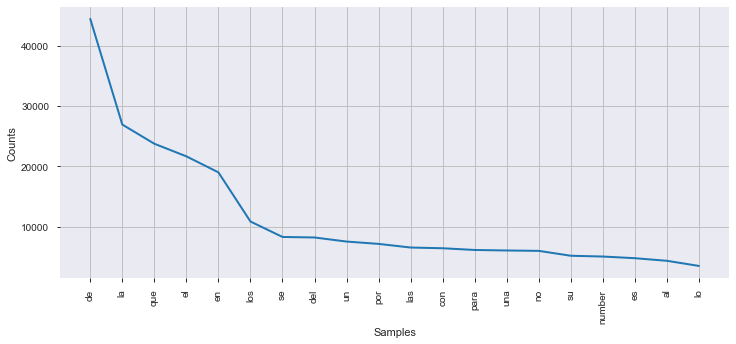

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [19]:
plt.figure(figsize=(12, 5))  # the size 
fdist.plot(20, cumulative=False)

### Una vez analizado el dataset completo y corroborando que tenemos muchas palabras que no aportan valor a los modelos que queremos usar, pasamos a limpiar aun mas nuestro dataset

#### Armamos nuestro listado de stop word 

In [20]:
#Lista de stopword de la libreria nltk
stop = list(stopwords.words('spanish'))
#Lista de signos depuntuacion
stop.extend(list(string.punctuation))

In [21]:
stop

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

#### Sacamos todas las palabras de stop word de nuestras noticias 

In [22]:
def stop_word(text):
    tokens_filtrados = []
    for t in text:
        if t not in stop:
            tokens_filtrados.append(t)
    return tokens_filtrados 

In [23]:
df.Text = df.Text.apply(stop_word)

In [24]:
df.head()

,Class,Text,Text_string
0,True,"[voces, extremistas, conocidas, ee, uu, cuentas, asociadas, movimiento, conocida, alt, right, ligadas, grupos, antisemitas, xenófobos, sido, eliminadas, plumazo, redes, sociales, facebook, instagram, trat]",algunas de las voces extremistas más conocidas de ee uu cuentas asociadas con al movimiento de la conocida como alt right ligadas grupos antisemitas xenófobos han sido eliminadas de un plumazo de la redes sociales facebook instagram se trat
1,True,"[después, casi, dos, años, medio, luchas, políticas, judiciales, donald, trump, presentado, hoy, proyecto, inmigración, unidos, proyecto, elaborado, yerno, asesor, donald, trump, jared, kushner, sólo, concreta, cosa]",después de casi dos años medio de luchas políticas judiciales donald trump ha presentado hoy su proyecto de inmigración para estados unidos es un proyecto elaborado por el yerno asesor de donald trump jared kushner que sólo concreta una cosa
2,True,"[dos, periodistas, birmanos, agencia, reuters, liberados, martes, recibir, perdón, presidente, país, tras, pasar, año, medio, prisión, revelar, matanza, ejército, minoría, musulmana, rohingya, wa, lone, kyaw, soe, oo]",dos periodistas birmanos de la agencia reuters fueron liberados este martes al recibir un perdón del presidente de su país tras pasar año medio en prisión por revelar una matanza del ejército contra la minoría musulmana rohingya wa lone kyaw soe oo
3,True,"[cuerpo, nacional, policía, detenido, cuatro, personas, acusadas, formar, parte, grupo, criminal, dedicado, tráfico, seres, humanos, frontera, francoespañola, irún, gipuzkoa, célula, captaba, extranjeros, llegados, pateras, of]",el cuerpo nacional de policía ha detenido cuatro personas acusadas de formar parte de un grupo criminal dedicado al tráfico de seres humanos en la frontera francoespañola de irún gipuzkoa esta célula captaba extranjeros llegados en pateras les of
4,True,"[desfile, firma, roma, convierte, oda, libertad, mujeres, decidir, propios, cuerpos, museos, capitolinos, roma, transformaron, noche, martes, escenario, presentar, colección, crucero]",el desfile de la firma en roma se convierte en una oda la libertad de las mujeres para decidir sobre sus propios cuerpos los museos capitolinos de roma se transformaron la noche del martes en escenario sobre el que presentar la colección crucero


### Realizamos el mismo analisis de frecuencia anterior para ver los cambios 

In [25]:
df['Text_string2'] = [' '.join(map(str, l)) for l in df['Text']]

In [26]:
all_words = ' '.join([word for word in df['Text_string2']])

In [27]:
tokenized_words = nltk.tokenize.word_tokenize(all_words)

In [28]:
fdist2 = FreqDist(tokenized_words)

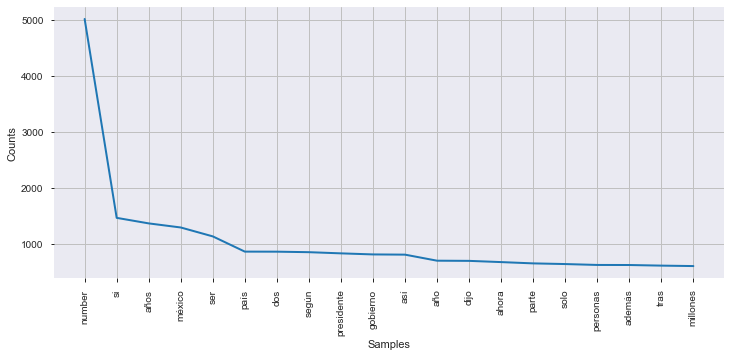

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [29]:
plt.figure(figsize=(12, 5))  # the size 
fdist2.plot(20, cumulative=False)

#### Seguimos viendo que tenemos palabras como "number" que necesitamos sacar y aprovecharemos a sacar aquellas palabras que tienen muy baja frecuencia

In [30]:
df_frecuencia = pd.DataFrame([[key, fdist2[key]] for key in fdist2.keys()], columns=['Token', 'Frecuencia'])

In [31]:
df_frecuencia.sort_values(by='Frecuencia', ascending=True)

,Token,Frecuencia
45363,chilindrina,1
15141,trancones,1
36729,pompeya,1
36730,busquets,1
15138,mijito,1
...,...,...
167,ser,1136
3572,méxico,1295
26,años,1368
471,si,1467


In [32]:
df_mask=df_frecuencia['Frecuencia']<3
filtered_df = df_frecuencia[df_mask]
filtered_df
stop2 = filtered_df['Token'].tolist()
stop2.append('number')

In [34]:
df.head()

,Class,Text,Text_string,Text_string2
0,True,"[voces, extremistas, conocidas, ee, uu, cuentas, asociadas, movimiento, conocida, alt, right, ligadas, grupos, antisemitas, xenófobos, sido, eliminadas, plumazo, redes, sociales, facebook, instagram, trat]",algunas de las voces extremistas más conocidas de ee uu cuentas asociadas con al movimiento de la conocida como alt right ligadas grupos antisemitas xenófobos han sido eliminadas de un plumazo de la redes sociales facebook instagram se trat,voces extremistas conocidas ee uu cuentas asociadas movimiento conocida alt right ligadas grupos antisemitas xenófobos sido eliminadas plumazo redes sociales facebook instagram trat
1,True,"[después, casi, dos, años, medio, luchas, políticas, judiciales, donald, trump, presentado, hoy, proyecto, inmigración, unidos, proyecto, elaborado, yerno, asesor, donald, trump, jared, kushner, sólo, concreta, cosa]",después de casi dos años medio de luchas políticas judiciales donald trump ha presentado hoy su proyecto de inmigración para estados unidos es un proyecto elaborado por el yerno asesor de donald trump jared kushner que sólo concreta una cosa,después casi dos años medio luchas políticas judiciales donald trump presentado hoy proyecto inmigración unidos proyecto elaborado yerno asesor donald trump jared kushner sólo concreta cosa
2,True,"[dos, periodistas, birmanos, agencia, reuters, liberados, martes, recibir, perdón, presidente, país, tras, pasar, año, medio, prisión, revelar, matanza, ejército, minoría, musulmana, rohingya, wa, lone, kyaw, soe, oo]",dos periodistas birmanos de la agencia reuters fueron liberados este martes al recibir un perdón del presidente de su país tras pasar año medio en prisión por revelar una matanza del ejército contra la minoría musulmana rohingya wa lone kyaw soe oo,dos periodistas birmanos agencia reuters liberados martes recibir perdón presidente país tras pasar año medio prisión revelar matanza ejército minoría musulmana rohingya wa lone kyaw soe oo
3,True,"[cuerpo, nacional, policía, detenido, cuatro, personas, acusadas, formar, parte, grupo, criminal, dedicado, tráfico, seres, humanos, frontera, francoespañola, irún, gipuzkoa, célula, captaba, extranjeros, llegados, pateras, of]",el cuerpo nacional de policía ha detenido cuatro personas acusadas de formar parte de un grupo criminal dedicado al tráfico de seres humanos en la frontera francoespañola de irún gipuzkoa esta célula captaba extranjeros llegados en pateras les of,cuerpo nacional policía detenido cuatro personas acusadas formar parte grupo criminal dedicado tráfico seres humanos frontera francoespañola irún gipuzkoa célula captaba extranjeros llegados pateras of
4,True,"[desfile, firma, roma, convierte, oda, libertad, mujeres, decidir, propios, cuerpos, museos, capitolinos, roma, transformaron, noche, martes, escenario, presentar, colección, crucero]",el desfile de la firma en roma se convierte en una oda la libertad de las mujeres para decidir sobre sus propios cuerpos los museos capitolinos de roma se transformaron la noche del martes en escenario sobre el que presentar la colección crucero,desfile firma roma convierte oda libertad mujeres decidir propios cuerpos museos capitolinos roma transformaron noche martes escenario presentar colección crucero


In [35]:
def stop_word(text):
    tokens_filtrados = []
    for t in text:
        if t not in stop2:
            tokens_filtrados.append(t)
    return tokens_filtrados 

In [36]:
df.Text = df.Text.apply(stop_word)

In [37]:
df.head()

,Class,Text,Text_string,Text_string2
0,True,"[voces, extremistas, conocidas, ee, uu, cuentas, asociadas, movimiento, conocida, alt, ligadas, grupos, xenófobos, sido, eliminadas, plumazo, redes, sociales, facebook, instagram, trat]",algunas de las voces extremistas más conocidas de ee uu cuentas asociadas con al movimiento de la conocida como alt right ligadas grupos antisemitas xenófobos han sido eliminadas de un plumazo de la redes sociales facebook instagram se trat,voces extremistas conocidas ee uu cuentas asociadas movimiento conocida alt right ligadas grupos antisemitas xenófobos sido eliminadas plumazo redes sociales facebook instagram trat
1,True,"[después, casi, dos, años, medio, luchas, políticas, judiciales, donald, trump, presentado, hoy, proyecto, inmigración, unidos, proyecto, elaborado, yerno, asesor, donald, trump, jared, kushner, sólo, concreta, cosa]",después de casi dos años medio de luchas políticas judiciales donald trump ha presentado hoy su proyecto de inmigración para estados unidos es un proyecto elaborado por el yerno asesor de donald trump jared kushner que sólo concreta una cosa,después casi dos años medio luchas políticas judiciales donald trump presentado hoy proyecto inmigración unidos proyecto elaborado yerno asesor donald trump jared kushner sólo concreta cosa
2,True,"[dos, periodistas, agencia, reuters, liberados, martes, recibir, perdón, presidente, país, tras, pasar, año, medio, prisión, revelar, matanza, ejército, minoría, musulmana, oo]",dos periodistas birmanos de la agencia reuters fueron liberados este martes al recibir un perdón del presidente de su país tras pasar año medio en prisión por revelar una matanza del ejército contra la minoría musulmana rohingya wa lone kyaw soe oo,dos periodistas birmanos agencia reuters liberados martes recibir perdón presidente país tras pasar año medio prisión revelar matanza ejército minoría musulmana rohingya wa lone kyaw soe oo
3,True,"[cuerpo, nacional, policía, detenido, cuatro, personas, acusadas, formar, parte, grupo, criminal, dedicado, tráfico, seres, humanos, frontera, gipuzkoa, célula, extranjeros, llegados, pateras, of]",el cuerpo nacional de policía ha detenido cuatro personas acusadas de formar parte de un grupo criminal dedicado al tráfico de seres humanos en la frontera francoespañola de irún gipuzkoa esta célula captaba extranjeros llegados en pateras les of,cuerpo nacional policía detenido cuatro personas acusadas formar parte grupo criminal dedicado tráfico seres humanos frontera francoespañola irún gipuzkoa célula captaba extranjeros llegados pateras of
4,True,"[desfile, firma, roma, convierte, libertad, mujeres, decidir, propios, cuerpos, museos, roma, noche, martes, escenario, presentar, colección]",el desfile de la firma en roma se convierte en una oda la libertad de las mujeres para decidir sobre sus propios cuerpos los museos capitolinos de roma se transformaron la noche del martes en escenario sobre el que presentar la colección crucero,desfile firma roma convierte oda libertad mujeres decidir propios cuerpos museos capitolinos roma transformaron noche martes escenario presentar colección crucero


#### Realiazamos el un ultimo analisis de frecuencia para ver como quedaron los datos

In [38]:
df['Text_string3'] = [' '.join(map(str, l)) for l in df['Text']]

In [39]:
all_words = ' '.join([word for word in df['Text_string3']])

In [40]:
tokenized_words = nltk.tokenize.word_tokenize(all_words)

In [41]:
fdist3 = FreqDist(tokenized_words)

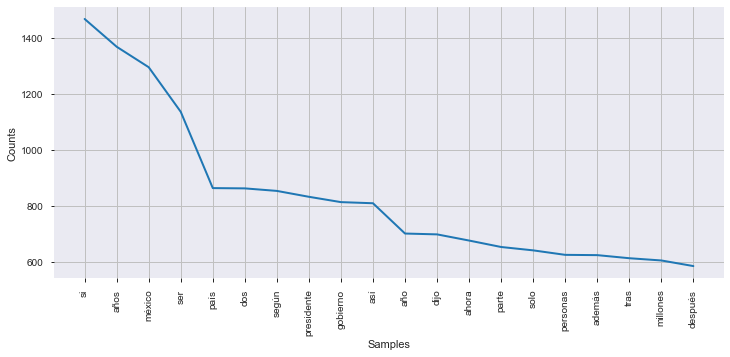

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [137]:
plt.figure(figsize=(12, 5))
fdist3.plot(20, cumulative=False)

#### Una vez conseguido el dataframe limpio podemos realizar la nube de palabras que nos ayudara a enter un poco mas que tenemos entre manos

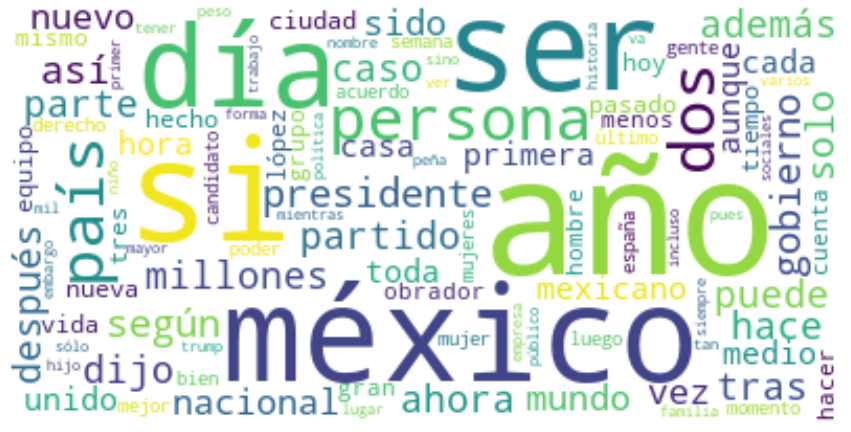

In [43]:
text = " ".join(i for i in df.Text_string3)
nWords = 100 
word_cloud = WordCloud(max_words = nWords, collocations = False, background_color = 'white').generate(text)
plt.figure( figsize=(15,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [44]:
df.head()

,Class,Text,Text_string,Text_string2,Text_string3
0,True,"[voces, extremistas, conocidas, ee, uu, cuentas, asociadas, movimiento, conocida, alt, ligadas, grupos, xenófobos, sido, eliminadas, plumazo, redes, sociales, facebook, instagram, trat]",algunas de las voces extremistas más conocidas de ee uu cuentas asociadas con al movimiento de la conocida como alt right ligadas grupos antisemitas xenófobos han sido eliminadas de un plumazo de la redes sociales facebook instagram se trat,voces extremistas conocidas ee uu cuentas asociadas movimiento conocida alt right ligadas grupos antisemitas xenófobos sido eliminadas plumazo redes sociales facebook instagram trat,voces extremistas conocidas ee uu cuentas asociadas movimiento conocida alt ligadas grupos xenófobos sido eliminadas plumazo redes sociales facebook instagram trat
1,True,"[después, casi, dos, años, medio, luchas, políticas, judiciales, donald, trump, presentado, hoy, proyecto, inmigración, unidos, proyecto, elaborado, yerno, asesor, donald, trump, jared, kushner, sólo, concreta, cosa]",después de casi dos años medio de luchas políticas judiciales donald trump ha presentado hoy su proyecto de inmigración para estados unidos es un proyecto elaborado por el yerno asesor de donald trump jared kushner que sólo concreta una cosa,después casi dos años medio luchas políticas judiciales donald trump presentado hoy proyecto inmigración unidos proyecto elaborado yerno asesor donald trump jared kushner sólo concreta cosa,después casi dos años medio luchas políticas judiciales donald trump presentado hoy proyecto inmigración unidos proyecto elaborado yerno asesor donald trump jared kushner sólo concreta cosa
2,True,"[dos, periodistas, agencia, reuters, liberados, martes, recibir, perdón, presidente, país, tras, pasar, año, medio, prisión, revelar, matanza, ejército, minoría, musulmana, oo]",dos periodistas birmanos de la agencia reuters fueron liberados este martes al recibir un perdón del presidente de su país tras pasar año medio en prisión por revelar una matanza del ejército contra la minoría musulmana rohingya wa lone kyaw soe oo,dos periodistas birmanos agencia reuters liberados martes recibir perdón presidente país tras pasar año medio prisión revelar matanza ejército minoría musulmana rohingya wa lone kyaw soe oo,dos periodistas agencia reuters liberados martes recibir perdón presidente país tras pasar año medio prisión revelar matanza ejército minoría musulmana oo
3,True,"[cuerpo, nacional, policía, detenido, cuatro, personas, acusadas, formar, parte, grupo, criminal, dedicado, tráfico, seres, humanos, frontera, gipuzkoa, célula, extranjeros, llegados, pateras, of]",el cuerpo nacional de policía ha detenido cuatro personas acusadas de formar parte de un grupo criminal dedicado al tráfico de seres humanos en la frontera francoespañola de irún gipuzkoa esta célula captaba extranjeros llegados en pateras les of,cuerpo nacional policía detenido cuatro personas acusadas formar parte grupo criminal dedicado tráfico seres humanos frontera francoespañola irún gipuzkoa célula captaba extranjeros llegados pateras of,cuerpo nacional policía detenido cuatro personas acusadas formar parte grupo criminal dedicado tráfico seres humanos frontera gipuzkoa célula extranjeros llegados pateras of
4,True,"[desfile, firma, roma, convierte, libertad, mujeres, decidir, propios, cuerpos, museos, roma, noche, martes, escenario, presentar, colección]",el desfile de la firma en roma se convierte en una oda la libertad de las mujeres para decidir sobre sus propios cuerpos los museos capitolinos de roma se transformaron la noche del martes en escenario sobre el que presentar la colección crucero,desfile firma roma convierte oda libertad mujeres decidir propios cuerpos museos capitolinos roma transformaron noche martes escenario presentar colección crucero,desfile firma roma convierte libertad mujeres decidir propios cuerpos museos roma noche martes escenario presentar colección


### Aplicacion de stemmer

#### Se aplica el stemmer para encontrar la raiz de la palabras y de esta manera evitar palabras que significarian lo mismo pero que cambiar para el modelo por tener plurar o femenino y masculino

In [45]:
stemmer = SnowballStemmer('spanish')
def stem_text(text):
    final_text = []
    for i in text.split(' '):
        word = stemmer.stem(i.strip())
        final_text.append(word)
    return " ".join(final_text) 

In [46]:
df['Text2'] = df.Text_string3.apply(stem_text)

In [47]:
df.head()

,Class,Text,Text_string,Text_string2,Text_string3,Text2
0,True,"[voces, extremistas, conocidas, ee, uu, cuentas, asociadas, movimiento, conocida, alt, ligadas, grupos, xenófobos, sido, eliminadas, plumazo, redes, sociales, facebook, instagram, trat]",algunas de las voces extremistas más conocidas de ee uu cuentas asociadas con al movimiento de la conocida como alt right ligadas grupos antisemitas xenófobos han sido eliminadas de un plumazo de la redes sociales facebook instagram se trat,voces extremistas conocidas ee uu cuentas asociadas movimiento conocida alt right ligadas grupos antisemitas xenófobos sido eliminadas plumazo redes sociales facebook instagram trat,voces extremistas conocidas ee uu cuentas asociadas movimiento conocida alt ligadas grupos xenófobos sido eliminadas plumazo redes sociales facebook instagram trat,voc extrem conoc ee uu cuent asoci movimient conoc alt lig grup xenofob sid elimin plumaz red social facebook instagram trat
1,True,"[después, casi, dos, años, medio, luchas, políticas, judiciales, donald, trump, presentado, hoy, proyecto, inmigración, unidos, proyecto, elaborado, yerno, asesor, donald, trump, jared, kushner, sólo, concreta, cosa]",después de casi dos años medio de luchas políticas judiciales donald trump ha presentado hoy su proyecto de inmigración para estados unidos es un proyecto elaborado por el yerno asesor de donald trump jared kushner que sólo concreta una cosa,después casi dos años medio luchas políticas judiciales donald trump presentado hoy proyecto inmigración unidos proyecto elaborado yerno asesor donald trump jared kushner sólo concreta cosa,después casi dos años medio luchas políticas judiciales donald trump presentado hoy proyecto inmigración unidos proyecto elaborado yerno asesor donald trump jared kushner sólo concreta cosa,despues casi dos años medi luch polit judicial donald trump present hoy proyect inmigr unid proyect elabor yern asesor donald trump jar kushn sol concret cos
2,True,"[dos, periodistas, agencia, reuters, liberados, martes, recibir, perdón, presidente, país, tras, pasar, año, medio, prisión, revelar, matanza, ejército, minoría, musulmana, oo]",dos periodistas birmanos de la agencia reuters fueron liberados este martes al recibir un perdón del presidente de su país tras pasar año medio en prisión por revelar una matanza del ejército contra la minoría musulmana rohingya wa lone kyaw soe oo,dos periodistas birmanos agencia reuters liberados martes recibir perdón presidente país tras pasar año medio prisión revelar matanza ejército minoría musulmana rohingya wa lone kyaw soe oo,dos periodistas agencia reuters liberados martes recibir perdón presidente país tras pasar año medio prisión revelar matanza ejército minoría musulmana oo,dos period agenci reuters liber mart recib perdon president pais tras pas año medi prision revel matanz ejercit minor musulman oo
3,True,"[cuerpo, nacional, policía, detenido, cuatro, personas, acusadas, formar, parte, grupo, criminal, dedicado, tráfico, seres, humanos, frontera, gipuzkoa, célula, extranjeros, llegados, pateras, of]",el cuerpo nacional de policía ha detenido cuatro personas acusadas de formar parte de un grupo criminal dedicado al tráfico de seres humanos en la frontera francoespañola de irún gipuzkoa esta célula captaba extranjeros llegados en pateras les of,cuerpo nacional policía detenido cuatro personas acusadas formar parte grupo criminal dedicado tráfico seres humanos frontera francoespañola irún gipuzkoa célula captaba extranjeros llegados pateras of,cuerpo nacional policía detenido cuatro personas acusadas formar parte grupo criminal dedicado tráfico seres humanos frontera gipuzkoa célula extranjeros llegados pateras of,cuerp nacional polic deten cuatr person acus form part grup criminal dedic trafic ser human fronter gipuzko celul extranjer lleg pater of
4,True,"[desfile, firma, roma, convierte, libertad, mujeres, decidir, propios, cuerpos, museos, roma, noche, martes, escenario, presentar, colección]",el 

#### Tambien analizamos si los datos estan balanceados

In [108]:
y.sum() / len(y)

0.5164866401364412

### Exportamos el dataset terminado a un archivo para poder realizar el modelado sin tener que ejecutar los pasos anteriores si tenemos que reiniciar el kernel

In [48]:
df.to_csv('fakeNews.csv', index=False)

### Importamos el dataset a modelar

In [49]:
df_modelo = pd.read_csv('fakeNews.csv')

In [50]:
df_modelo.head()

,Class,Text,Text_string,Text_string2,Text_string3,Text2
0,True,"['voces', 'extremistas', 'conocidas', 'ee', 'uu', 'cuentas', 'asociadas', 'movimiento', 'conocida', 'alt', 'ligadas', 'grupos', 'xenófobos', 'sido', 'eliminadas', 'plumazo', 'redes', 'sociales', 'facebook', 'instagram', 'trat']",algunas de las voces extremistas más conocidas de ee uu cuentas asociadas con al movimiento de la conocida como alt right ligadas grupos antisemitas xenófobos han sido eliminadas de un plumazo de la redes sociales facebook instagram se trat,voces extremistas conocidas ee uu cuentas asociadas movimiento conocida alt right ligadas grupos antisemitas xenófobos sido eliminadas plumazo redes sociales facebook instagram trat,voces extremistas conocidas ee uu cuentas asociadas movimiento conocida alt ligadas grupos xenófobos sido eliminadas plumazo redes sociales facebook instagram trat,voc extrem conoc ee uu cuent asoci movimient conoc alt lig grup xenofob sid elimin plumaz red social facebook instagram trat
1,True,"['después', 'casi', 'dos', 'años', 'medio', 'luchas', 'políticas', 'judiciales', 'donald', 'trump', 'presentado', 'hoy', 'proyecto', 'inmigración', 'unidos', 'proyecto', 'elaborado', 'yerno', 'asesor', 'donald', 'trump', 'jared', 'kushner', 'sólo', 'concreta', 'cosa']",después de casi dos años medio de luchas políticas judiciales donald trump ha presentado hoy su proyecto de inmigración para estados unidos es un proyecto elaborado por el yerno asesor de donald trump jared kushner que sólo concreta una cosa,después casi dos años medio luchas políticas judiciales donald trump presentado hoy proyecto inmigración unidos proyecto elaborado yerno asesor donald trump jared kushner sólo concreta cosa,después casi dos años medio luchas políticas judiciales donald trump presentado hoy proyecto inmigración unidos proyecto elaborado yerno asesor donald trump jared kushner sólo concreta cosa,despues casi dos años medi luch polit judicial donald trump present hoy proyect inmigr unid proyect elabor yern asesor donald trump jar kushn sol concret cos
2,True,"['dos', 'periodistas', 'agencia', 'reuters', 'liberados', 'martes', 'recibir', 'perdón', 'presidente', 'país', 'tras', 'pasar', 'año', 'medio', 'prisión', 'revelar', 'matanza', 'ejército', 'minoría', 'musulmana', 'oo']",dos periodistas birmanos de la agencia reuters fueron liberados este martes al recibir un perdón del presidente de su país tras pasar año medio en prisión por revelar una matanza del ejército contra la minoría musulmana rohingya wa lone kyaw soe oo,dos periodistas birmanos agencia reuters liberados martes recibir perdón presidente país tras pasar año medio prisión revelar matanza ejército minoría musulmana rohingya wa lone kyaw soe oo,dos periodistas agencia reuters liberados martes recibir perdón presidente país tras pasar año medio prisión revelar matanza ejército minoría musulmana oo,dos period agenci reuters liber mart recib perdon president pais tras pas año medi prision revel matanz ejercit minor musulman oo
3,True,"['cuerpo', 'nacional', 'policía', 'detenido', 'cuatro', 'personas', 'acusadas', 'formar', 'parte', 'grupo', 'criminal', 'dedicado', 'tráfico', 'seres', 'humanos', 'frontera', 'gipuzkoa', 'célula', 'extranjeros', 'llegados', 'pateras', 'of']",el cuerpo nacional de policía ha detenido cuatro personas acusadas de formar parte de un grupo criminal dedicado al tráfico de seres humanos en la frontera francoespañola de irún gipuzkoa esta célula captaba extranjeros llegados en pateras les of,cuerpo nacional policía detenido cuatro personas acusadas formar parte grupo criminal dedicado tráfico seres humanos frontera francoespañola irún gipuzkoa célula captaba extranjeros llegados pateras of,cuerpo nacional policía detenido cuatro personas acusadas formar parte grupo criminal dedicado tráfico seres humanos frontera gipuzkoa célula extranjeros llegados pateras of,cuerp nacional polic deten cuatr person acus form part grup criminal dedic trafic ser human fronter gipuzko celu

### En esta etapa ya solo usaremos las columnas Class y Text2 por lo que dropearemos el resto

In [51]:
df_modelo.drop(['Text','Text_string','Text_string2','Text_string3'], axis=1)

,Class,Text2
0,True,voc extrem conoc ee uu cuent asoci movimient conoc alt lig grup xenofob sid elimin plumaz red social facebook instagram trat
1,True,despues casi dos años medi luch polit judicial donald trump present hoy proyect inmigr unid proyect elabor yern asesor donald trump jar kushn sol concret cos
2,True,dos period agenci reuters liber mart recib perdon president pais tras pas año medi prision revel matanz ejercit minor musulman oo
3,True,cuerp nacional polic deten cuatr person acus form part grup criminal dedic trafic ser human fronter gipuzko celul extranjer lleg pater of
4,True,desfil firm rom conviert libert mujer decid propi cuerp muse rom noch mart escenari present coleccion
...,...,...
3513,True,meryl streep disfrut premi oscar tan mexican vin mexic streep va ser director washington post artesan guanajuat actriz estadounidens meryl streep gan premi mejor actriz academi cinematograf pais parec numer coc dos pas escenari guillerm tor volv mexic medi red social dos joven san miguel allend guanajuat trabaj tiend artesan local encuentr famos actriz mientr pas ciud huffpost mexic contact jov volv viral presenci streep señor amabl relat alex jov años trabaj tiend rop ubic san francisc plaz principal centr san miguel allend coment ven acompañ dos mujer pris lind tom unas fot experient dur apen minut suficient pod salud actric dej fotograf joven compart fot streep visit fot vio content relaj llev sombrer ala par chav identific actriz dej grat recuerd hab conoc encarn director washington post val recient oscar aunqu actriz sid pid permit descans disfrut popul local dio conoc reporter jesus agu
3514,False,plagi lan rey radioh acord ambos lan rey anunc ener traves red social twitt band britan radioh plan celebr cancion creep tem get fre recient descubiert estrategi marketing gener ruid promocion gratuit it tru the my song by creep radioh it and of the up to the will so we will deal with it in lan rey lan rey quier reproduccion radioh decadent lan rey estil vec depriment vec problem logr impact pued logr estrell pop ejempl taylor swift grand part radioh pes ser band mitic trayectori enorm tiemp aparec necesit impuls reproduccion plataform spotify lan rey vs radioh creep vs get fre mod ambos artist acord rey hic pequeñ guiñ cancion band casual famos grup asi dar habl traves red social despert trending titular medi especializ asi gran cantid busqued reproduccion ambos tem youtub spotify apple music
3515,True,ricard arjon lanz seri documental youtub sol circ soled compuest ocho capitul ultim trabaj cantautor guatemaltec lanz mundial sol circ soled seri documental mism arjon trabaj import tod carrer ocho capitul material recorr construccion ultim album circ soled primer vez disc habit lug viv personaj histori traves canal youtub vev artist capitul seman primer viern juni
3516,True,raul araiz sorprend andre legarret bes boc vay peg vay peg amor años dij conductor raul araiz sorprend andre bes boc transmision ayer program hoy conductor dispon hac pregunt legarret part jueg embarg acerc dij ¿qu gust ¿qu maner bes boc inmediat despues sonris araiz justific asi acab pas vay peg vay peg amor años oye si novel dab legarret sonris acerc araiz dio abraz signific pas ambos pues dij conductor habl detras cam tras recient incident program


### Importamos las librerias para el modelado y el analisis de metricas

In [109]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score 
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score,roc_curve, auc, plot_roc_curve, classification_report

### Definiremos una funcion para evaluar nuestros modelos

In [159]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_prob_train = model.predict_proba(X_train)[:, 1]
    y_prob_test = model.predict_proba(X_test)[:, 1]

    metrics = {
        'Precision': [
            precision_score(y_train, y_pred_train, pos_label=1),
            precision_score(y_test, y_pred_test, pos_label=1)
        ],
        'Recall': [
            recall_score(y_train, y_pred_train, pos_label=1),
            recall_score(y_test, y_pred_test, pos_label=1)
        ],
        'F1': [
            f1_score(y_train, y_pred_train, pos_label=1),
            f1_score(y_test, y_pred_test, pos_label=1)
        ],
        'Accuracy': [
            accuracy_score(y_train, y_pred_train),
            accuracy_score(y_test, y_pred_test)
        ],
        'MCC': [
            matthews_corrcoef(y_train, y_pred_train),
            matthews_corrcoef(y_test, y_pred_test)
        ],
        'Roc-Auc': [
            roc_auc_score(y_train, y_prob_train),
            roc_auc_score(y_test, y_prob_test)
        ]
    }

    display(pd.DataFrame(metrics, index=['Train set', 'Test set']))

    cf_matrix = confusion_matrix(y_test, y_pred_test)

    categories = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = [
        '{0:.2%}'.format(value)
        for value in cf_matrix.flatten() / np.sum(cf_matrix)
    ]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train, pos_label=1)
    roc_auc_train = auc(fpr_train, tpr_train)

    fpr_val, tpr_val, _ = roc_curve(y_test, y_prob_test, pos_label=1)
    roc_auc_val = auc(fpr_val, tpr_val)

    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    
   
    sn.heatmap(cf_matrix,
                annot=labels,
                cmap='Reds',
                fmt='',
                xticklabels=categories,
                yticklabels=categories,
                ax=ax[0])

    ax[0].set_xlabel("Predicted values", fontdict={'size': 12}, labelpad=10)
    ax[0].set_ylabel("Actual values", fontdict={'size': 12}, labelpad=10)
    ax[0].set_title("Confusion Matrix", fontdict={'size': 16}, pad=20)

    ax[1].plot(fpr_train,
               tpr_train,
               color='red',
               label='ROC curve Train (area = %0.3f)' % roc_auc_train)
    ax[1].plot(fpr_val,
               tpr_val,
               color='blue',
               label='ROC curve Test (area = %0.3f)' % roc_auc_val)
    ax[1].plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    ax[1].set_xlabel('False Positive Rate', fontdict={'size': 12}, labelpad=10)
    ax[1].set_ylabel('True Positive Rate', fontdict={'size': 12}, labelpad=10)
    ax[1].set_xlim([0, 1])
    ax[1].set_ylim([0, 1])
    ax[1].set_title('ROC Curve', fontdict={'size': 16}, pad=20)
    ax[1].legend(loc="lower right")
    ax[1].grid()

    plt.show()
    return cf_matrix

### Definimos el modelo de negocio: se supone que los medios publicaran solo aquellas noticias que el modelo prediga como verdaderos pero dependiendo el tipo de medio en el que estemos le daran distinto valores a los errores del modelo

In [156]:
evaluacion_negocio = pd.DataFrame()
evaluacion_negocio['Modelo'] = ['Perfecto']
evaluacion_negocio['Cronica'] = [(df['Class'].count())*500]
evaluacion_negocio['Chequeado'] = [(df['Class'].count())*500]

In [157]:
evaluacion_negocio

,Modelo,Cronica,Chequeado
0,Perfecto,1759000,1759000


In [158]:
def eval_negocio(model,cf_matrix):
    # Los aciertos seran valorados igualmente por ambos medios
    aciertos=500
    # Medio de comunicacion sensacionalista
    # falso positivo no tendra mucha importancia ya que de por si no tienen mucha credibilidad
    cronica_fp=-250
    # verdadero negativo tendra mucha importancia por que significa la perdida de la primicia
    cronica_vn=-1000
    # Medio de comunicacion "Serio"
    # falso positivo tendra mucha importancia por que significa la perdida de credibilidad
    chequeado_fp=-1000
    # verdadero negativo no tendra mucha importancia por que siginifica la perdida de la primicia pero no pone en riesgo la credibiidad
    chequeado_vn=-250
    cronica_evaluacion_modelo=cf_matrix[0][0]*aciertos+cf_matrix[1][1]*aciertos+cf_matrix[0][1]*cronica_fp+cf_matrix[1][0]*cronica_vn
    chequeado_evaluacion_modelo=cf_matrix[0][0]*aciertos+cf_matrix[1][1]*aciertos+cf_matrix[0][1]*chequeado_fp+cf_matrix[1][0]*chequeado_vn
    evaluacion={'Modelo':model,'Cronica':cronica_evaluacion_modelo,'Chequeado':chequeado_evaluacion_modelo}
    
    return evaluacion

### Seleccionamos nuestra variable independiente y nuestro target

In [53]:
x = df.Text2
y = df.Class

### Dividimos nuestro dataset en train y test

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### Vectorizamos nuestros textos

In [55]:
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

### Entrenaremos los modelos primero de la manera mas simple posible y luego usando la funcion gridSearch para ver si conseguimos alguna mejora en los rendimientos

### Regresion logistica

#### Sin gridSearch

,Precision,Recall,F1,Accuracy,MCC,Roc-Auc
Train set,0.931011,0.940000,0.935484,0.933191,0.866260,0.980180
Test set,0.779221,0.817439,0.797872,0.784091,0.567198,0.864359


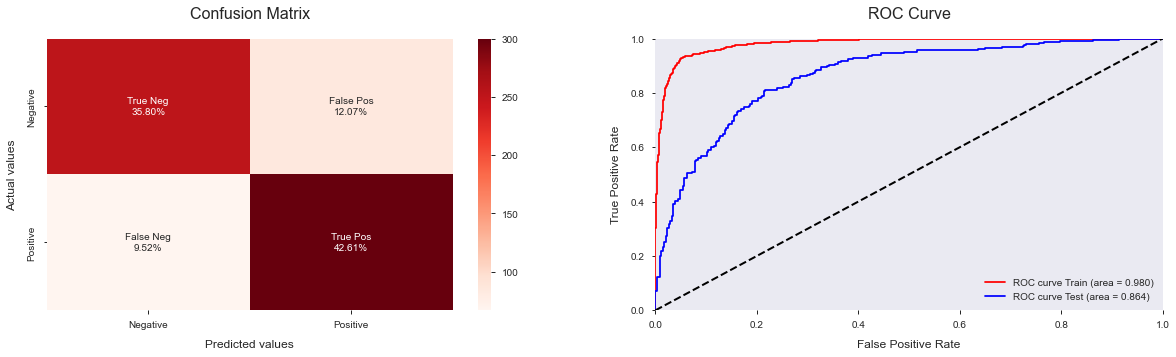

In [160]:
LR = LogisticRegression()
LR.fit(xv_train,y_train)
matrix=evaluate_model(LR, xv_train, y_train, xv_test, y_test)
evaluacion_negocio=evaluacion_negocio.append(pd.Series(eval_negocio('Regresion Logistica',matrix), index=evaluacion_negocio.columns),ignore_index=True)

#### Con GridSearch

Los mejores parametros encontrados son: {'C': 1.0, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'newton-cg'}


,Precision,Recall,F1,Accuracy,MCC,Roc-Auc
Train set,0.931011,0.940000,0.935484,0.933191,0.866260,0.980182
Test set,0.779221,0.817439,0.797872,0.784091,0.567198,0.864342


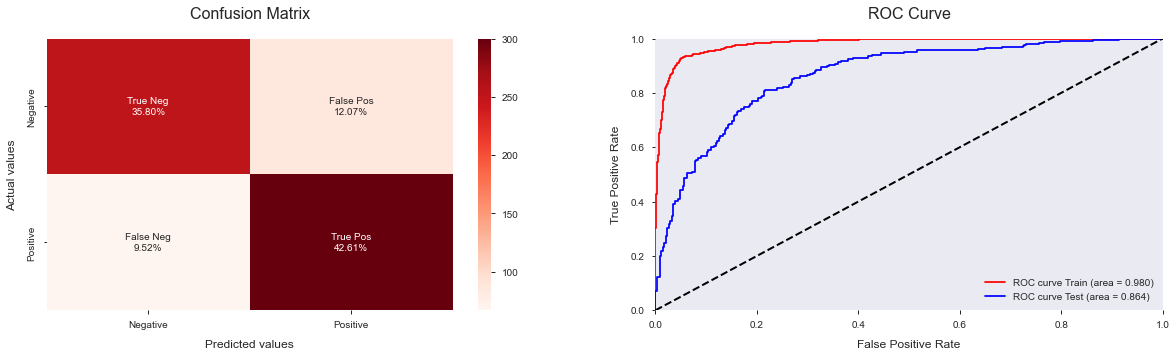

In [134]:
import warnings
warnings.filterwarnings('ignore')
parametros={
    'solver':['newton-cg', 'lbfgs', 'liblinear'],
    'fit_intercept':[True, False],
    'C':np.logspace(-3,3,7),
    'penalty':['none', 'l1', 'l2', 'elasticnet']
}
LR = GridSearchCV(LogisticRegression(),parametros, cv=None)
LR.fit(xv_train, y_train)
print('Los mejores parametros encontrados son:',LR.best_params_)
matrix=evaluate_model(LR, xv_train, y_train, xv_test, y_test)
#evaluacion_negocio.append(eval_negocio('Regresion Logistica GS',matrix))
evaluacion_negocio=evaluacion_negocio.append(pd.Series(eval_negocio('Regresion Logistica GS',matrix), index=evaluacion_negocio.columns),ignore_index=True)

### Arbol de desicion

Los mejores parametros encontrados son: {'criterion': 'gini', 'max_depth': 70}


,Precision,Recall,F1,Accuracy,MCC,Roc-Auc
Train set,1.00000,0.875172,0.933431,0.935679,0.879002,0.989933
Test set,0.69279,0.602180,0.644315,0.653409,0.312472,0.677710


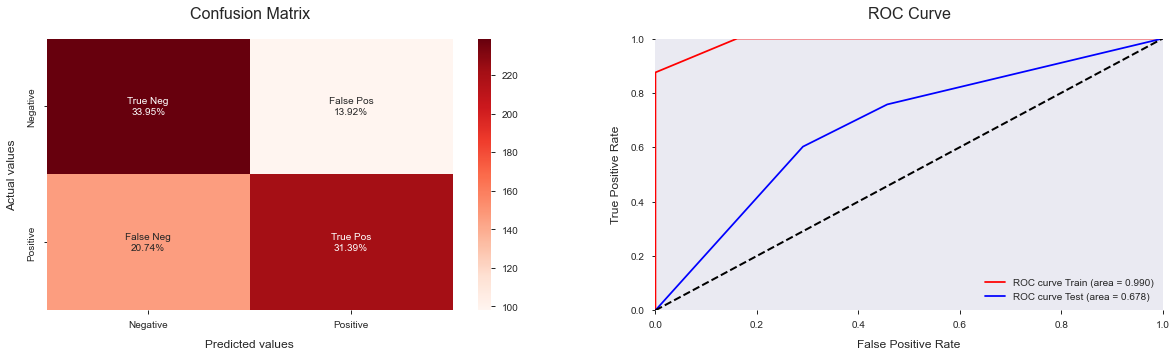

In [155]:
parametros = {
    'criterion':['gini','entropy'],
    'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
}
DT = GridSearchCV(DecisionTreeClassifier(), parametros, cv=None)
DT.fit(xv_train, y_train)
print('Los mejores parametros encontrados son:',DT.best_params_)
matrix=evaluate_model(DT, xv_train, y_train, xv_test, y_test)
#evaluacion_negocio.append(eval_negocio('Arbol de desicion GS',matrix))
evaluacion_negocio=evaluacion_negocio.append(pd.Series(eval_negocio('Arbol de desicion GS',matrix), index=evaluacion_negocio.columns),ignore_index=True)

### Random Forest

#### Sin GridSearch

,Precision,Recall,F1,Accuracy,MCC,Roc-Auc
Train set,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
Test set,0.805797,0.757493,0.780899,0.778409,0.558283,0.86581


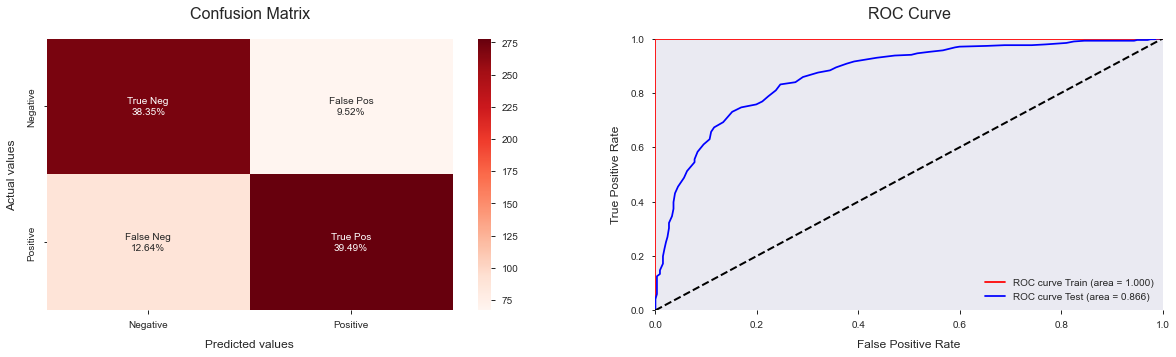

In [138]:
RFC = RandomForestClassifier(random_state=0)
RFC.fit(xv_train, y_train)
matrix=evaluate_model(RFC, xv_train, y_train, xv_test, y_test)
#evaluacion_negocio.append(eval_negocio('Random Forest',matrix))
evaluacion_negocio=evaluacion_negocio.append(pd.Series(eval_negocio('Random Forest',matrix), index=evaluacion_negocio.columns),ignore_index=True)

#### Con GridSearch

Los mejores parametros encontrados son: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}


,Precision,Recall,F1,Accuracy,MCC,Roc-Auc
Train set,0.788895,0.94069,0.858131,0.839730,0.691122,0.945837
Test set,0.723744,0.86376,0.787578,0.757102,0.520010,0.848058


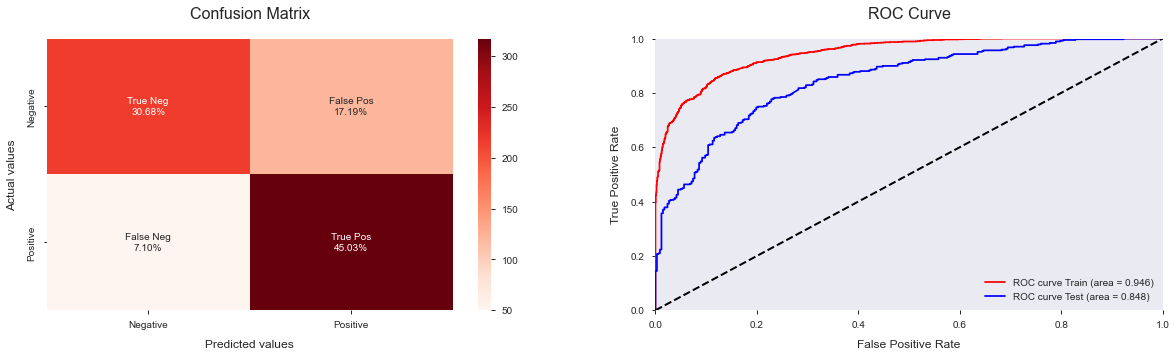

In [139]:
parametros = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
RF = GridSearchCV(RandomForestClassifier(), parametros, cv=None)
RF.fit(xv_train, y_train)
print('Los mejores parametros encontrados son:',RF.best_params_)
matrix=evaluate_model(RF, xv_train, y_train, xv_test, y_test)
#evaluacion_negocio.append(eval_negocio('Random Forest',matrix))
evaluacion_negocio=evaluacion_negocio.append(pd.Series(eval_negocio('Random Forest GS',matrix), index=evaluacion_negocio.columns),ignore_index=True)

### Bayes ingenuo

### Sin GridSearch

,Precision,Recall,F1,Accuracy,MCC,Roc-Auc
Train set,0.900268,0.927586,0.913723,0.909737,0.819535,0.971587
Test set,0.770171,0.858311,0.811856,0.792614,0.586594,0.854559


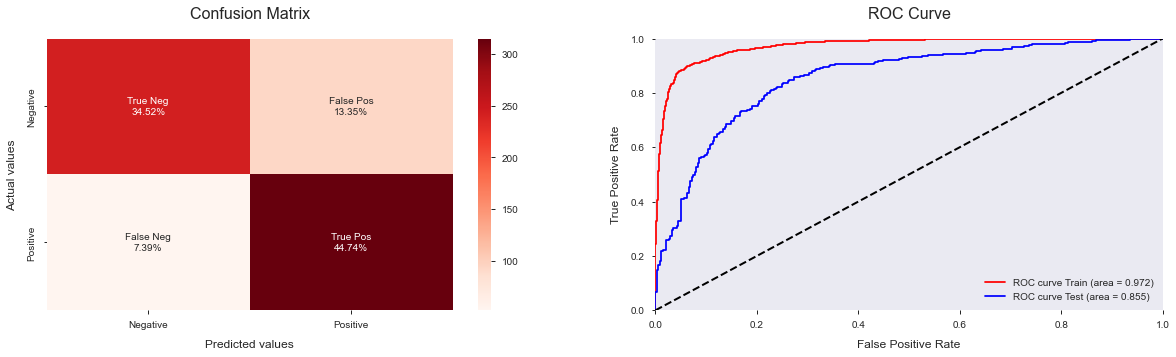

In [140]:
NB = MultinomialNB()
NB.fit(xv_train, y_train)
matrix = evaluate_model(NB, xv_train, y_train, xv_test, y_test)
evaluacion_negocio=evaluacion_negocio.append(pd.Series(eval_negocio('Bayes Ingenuo',matrix), index=evaluacion_negocio.columns),ignore_index=True)

#### Con Grid Search

Los mejores parametros encontrados son: {'alpha': 1, 'fit_prior': False}


,Precision,Recall,F1,Accuracy,MCC,Roc-Auc
Train set,0.908532,0.917931,0.913208,0.910092,0.820005,0.971587
Test set,0.779188,0.836512,0.806833,0.791193,0.581984,0.854559


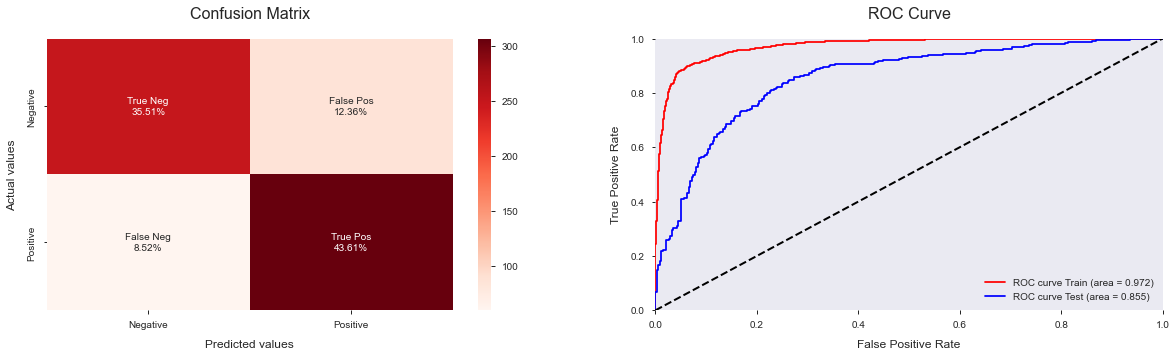

In [147]:
parametros = {'fit_prior': (True, False),
              'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)
             }
NB = GridSearchCV(MultinomialNB(), parametros, cv= None)
NB.fit(xv_train, y_train)
print('Los mejores parametros encontrados son:',RN.best_params_)
matrix = evaluate_model(NB, xv_train, y_train, xv_test, y_test)
evaluacion_negocio=evaluacion_negocio.append(pd.Series(eval_negocio('Bayes Ingenuo GS',matrix), index=evaluacion_negocio.columns),ignore_index=True)

### Redes neuronales

#### Sin Grid Search

,Precision,Recall,F1,Accuracy,MCC,Roc-Auc
Train set,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000
Test set,0.764858,0.80654,0.785146,0.769886,0.538692,0.848843


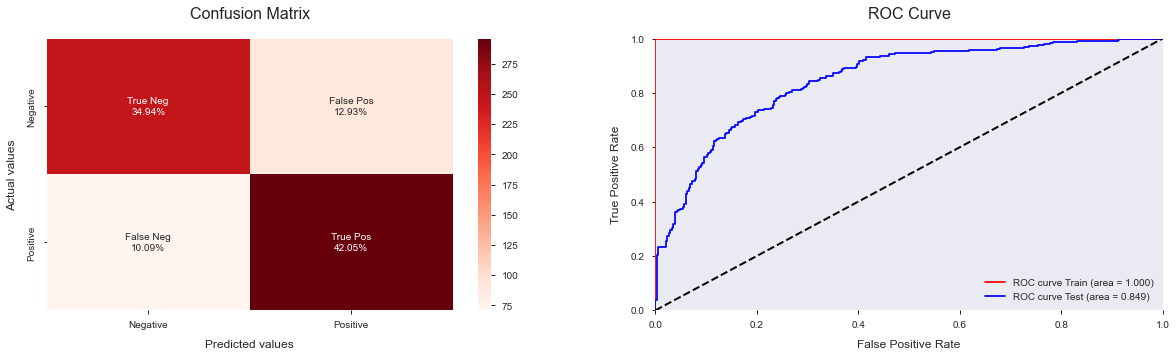

In [148]:
RN = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=1)
RN.fit(xv_train, y_train)
matrix = evaluate_model(RN, xv_train, y_train, xv_test, y_test)
evaluacion_negocio=evaluacion_negocio.append(pd.Series(eval_negocio('Redes Neuronales',matrix), index=evaluacion_negocio.columns),ignore_index=True)

#### Con Grid Search

Los mejores parametros encontrados son: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'adaptive', 'solver': 'adam'}


,Precision,Recall,F1,Accuracy,MCC,Roc-Auc
Train set,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Test set,0.761421,0.817439,0.788436,0.771307,0.541889,0.851042


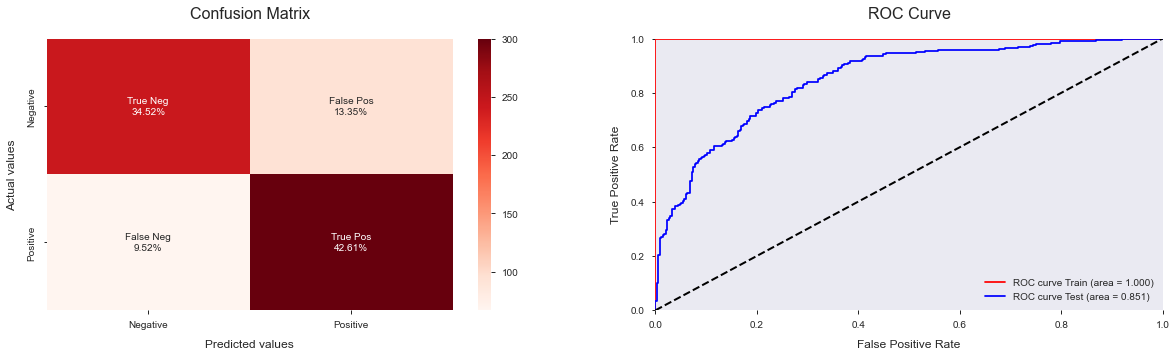

In [151]:
parametros = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
RN = GridSearchCV(MLPClassifier(), parametros, cv=None)
RN.fit(xv_train, y_train)
print('Los mejores parametros encontrados son:',RN.best_params_)
matrix = evaluate_model(RN, xv_train, y_train, xv_test, y_test)
evaluacion_negocio=evaluacion_negocio.append(pd.Series(eval_negocio('Redes Neuronales GS',matrix), index=evaluacion_negocio.columns),ignore_index=True)

In [162]:
evaluacion_negocio

,Modelo,Cronica,Chequeado
0,Perfecto,1759000,1759000
1,Regresion Logistica,187750,174250


#### Gracias a a funcion creada ahora podemos ver que para un medio sensacionalista el mejor modelo sera Bayes inguenuo

In [163]:
evaluacion_negocio.sort_values('Cronica',ascending = False )

,Modelo,Cronica,Chequeado
0,Perfecto,1759000,1759000
1,Regresion Logistica,187750,174250


#### Y para un medio serio el mejor modelo seria redes neuronaes con grid search

In [164]:
evaluacion_negocio.sort_values('Chequeado',ascending = False )

,Modelo,Cronica,Chequeado
0,Perfecto,1759000,1759000
1,Regresion Logistica,187750,174250
